## Percobaan 1

Resize dan Grayscale

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [2]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Konversi ke grayscale
            img = cv.resize(img, (150, 150))           # Resize ke ukuran tetap
            img = img.astype(np.uint8)                 # Tipe data sesuai

            data.append(img)
            labels.append(sub_folder)
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)


## Data Preparation

### Tanpa Preprocessing

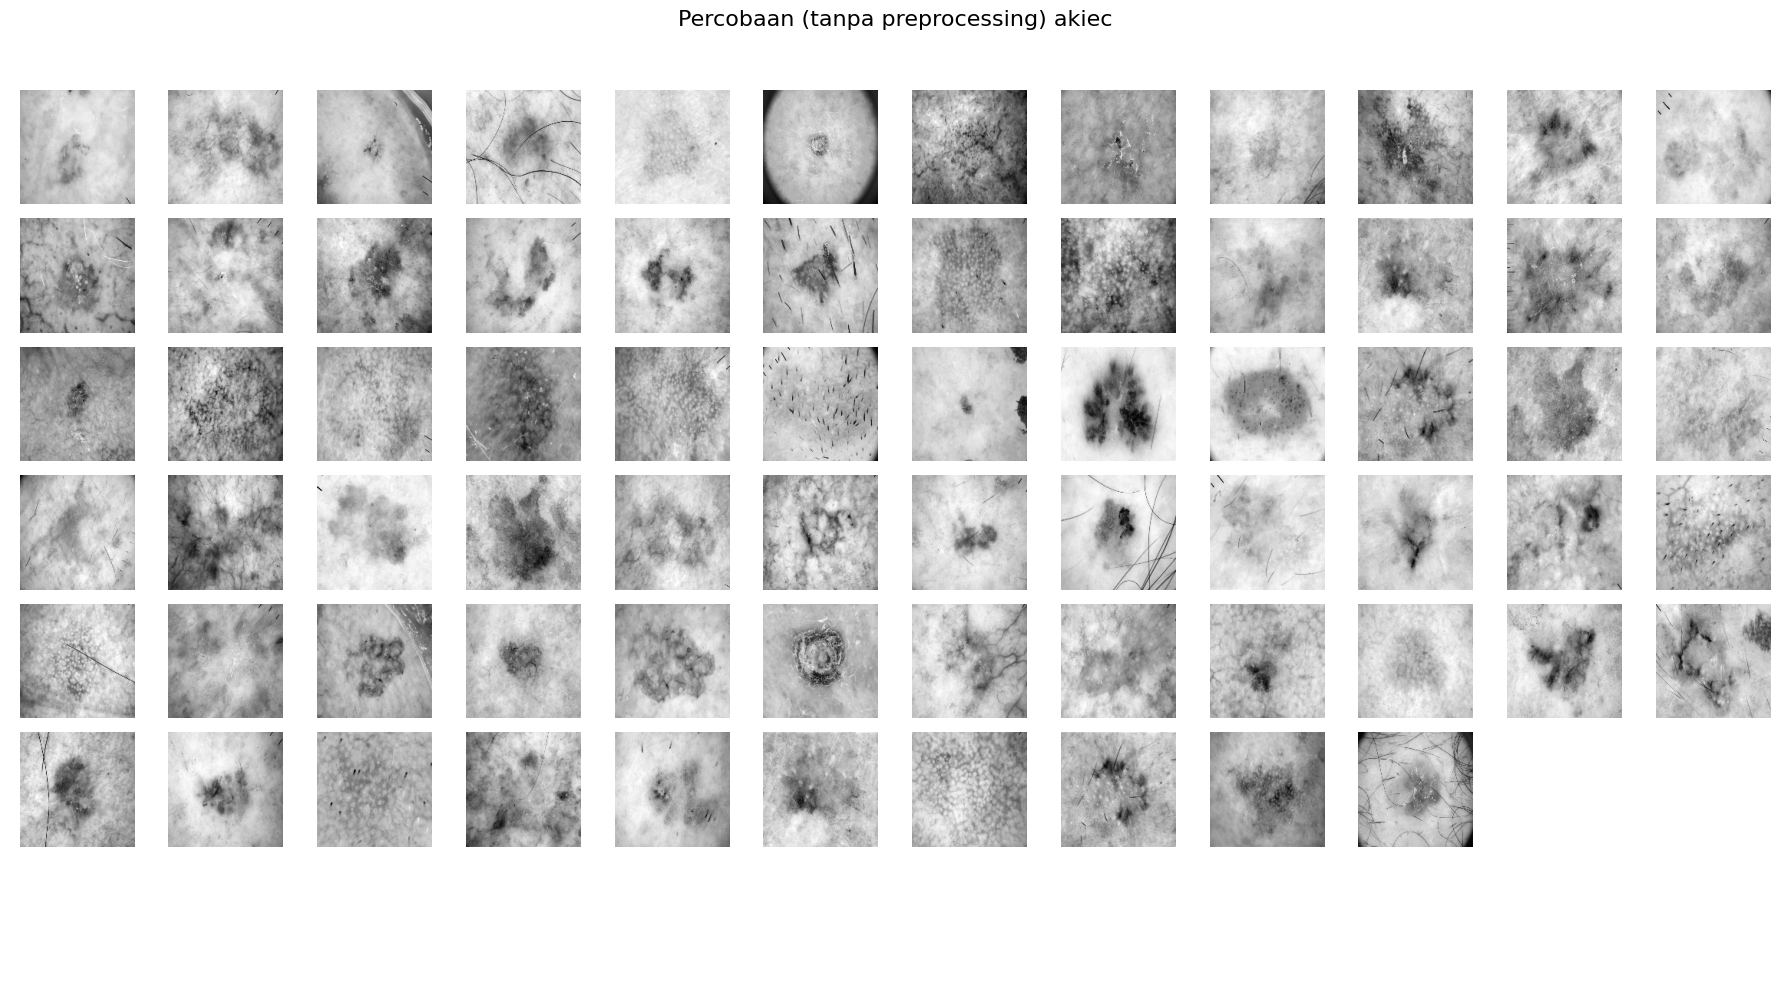

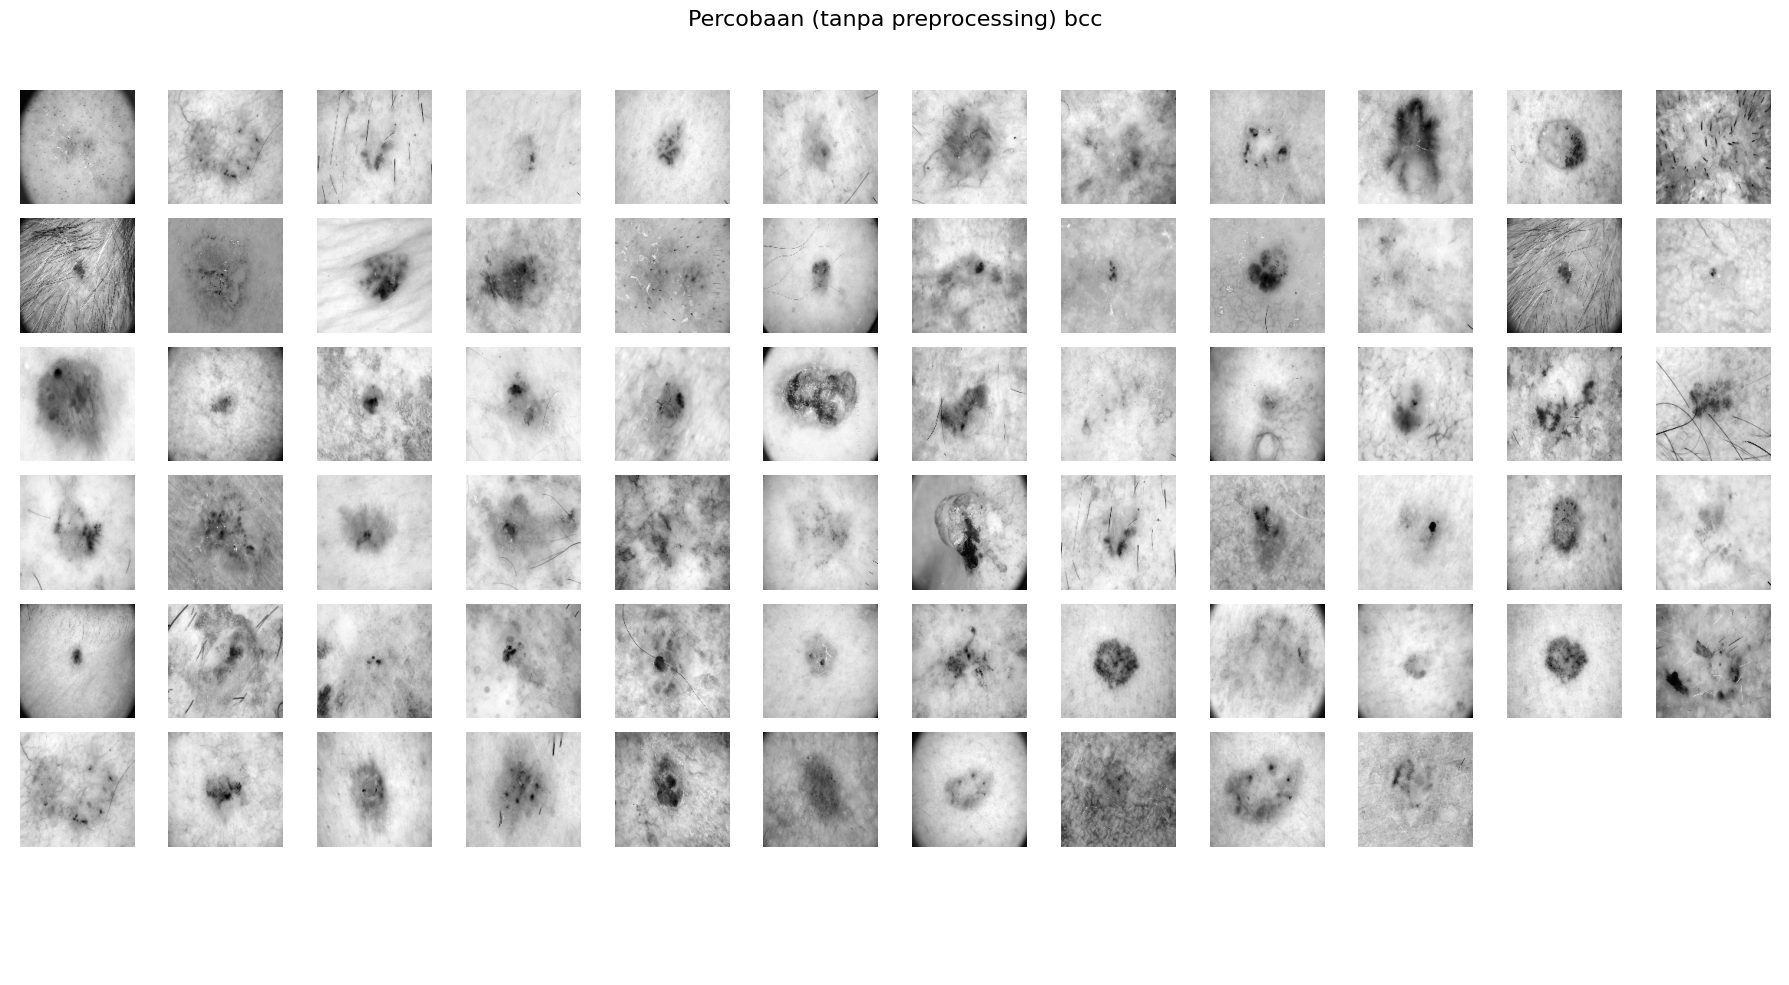

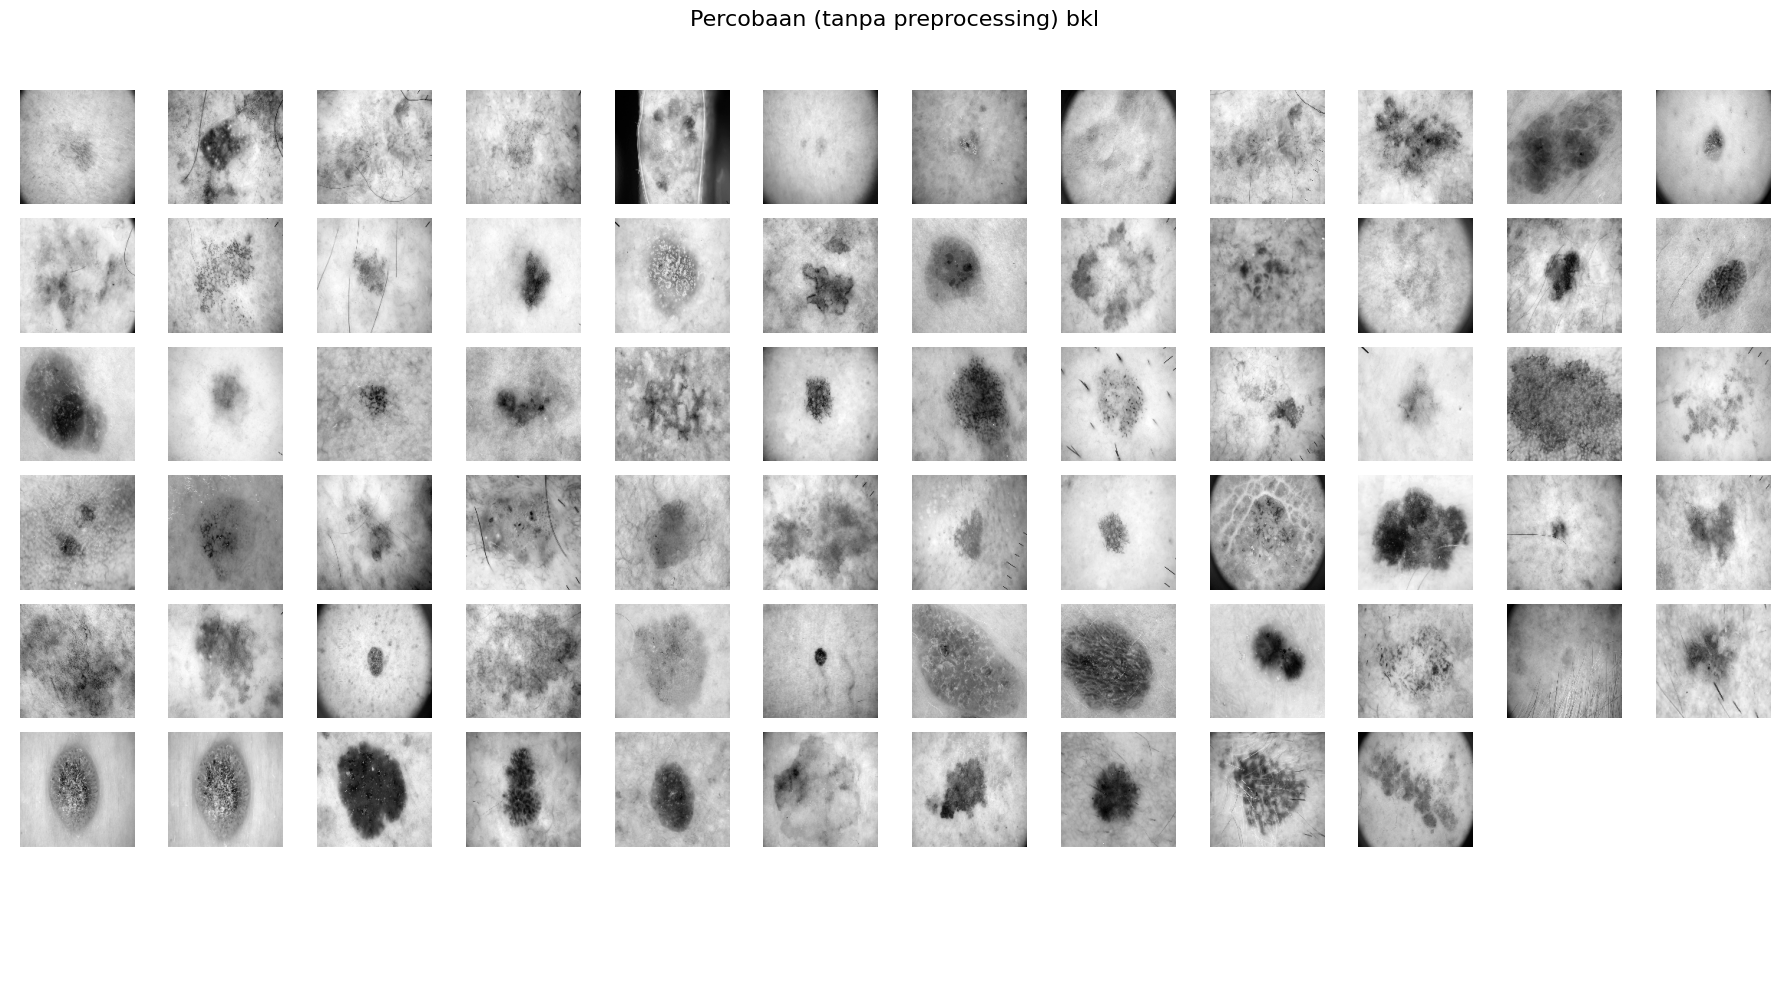

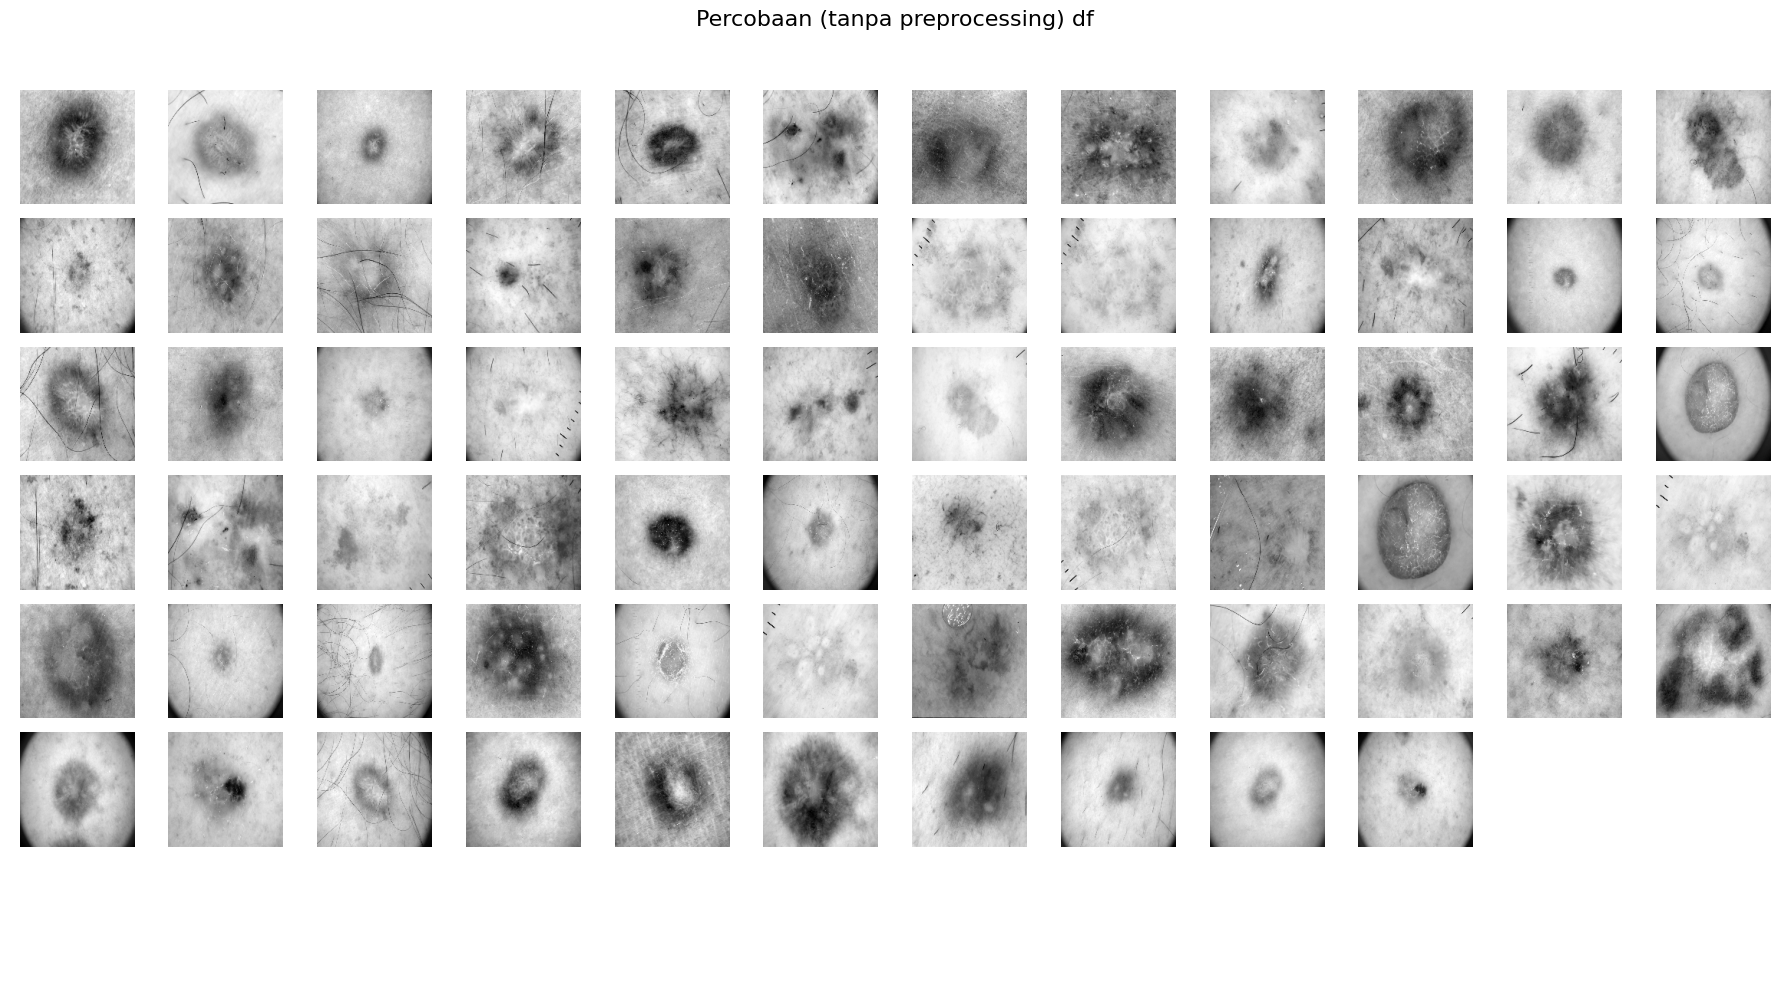

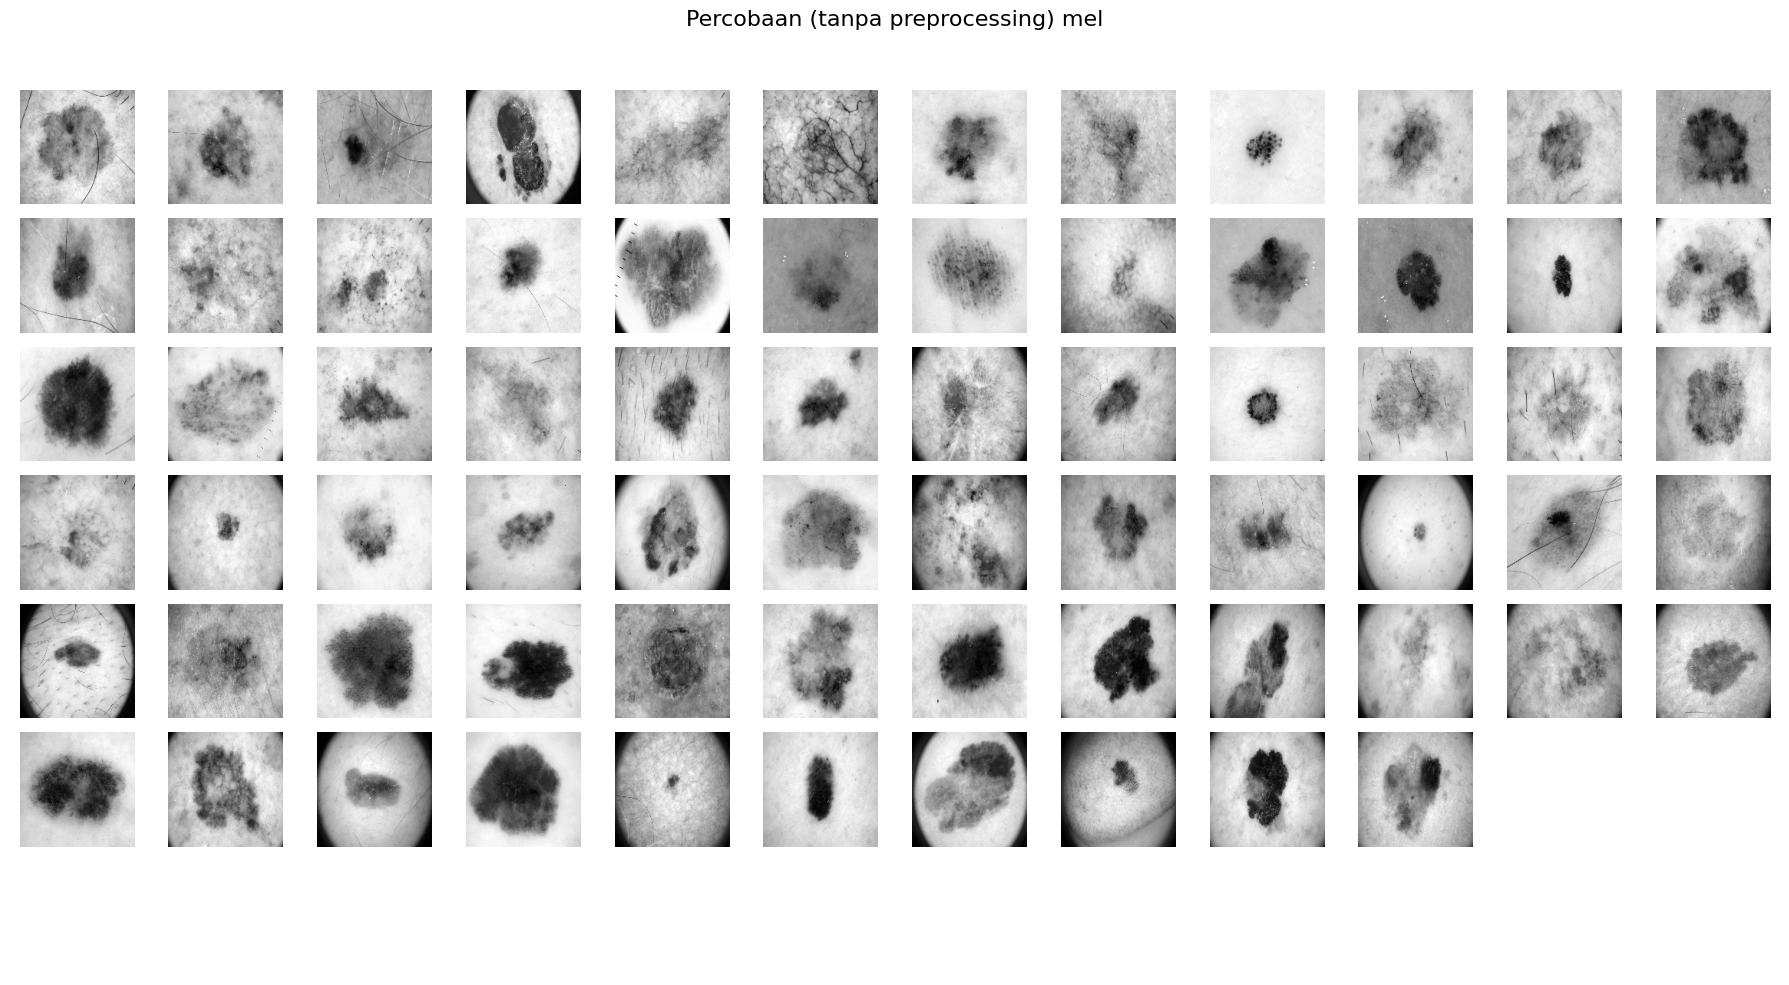

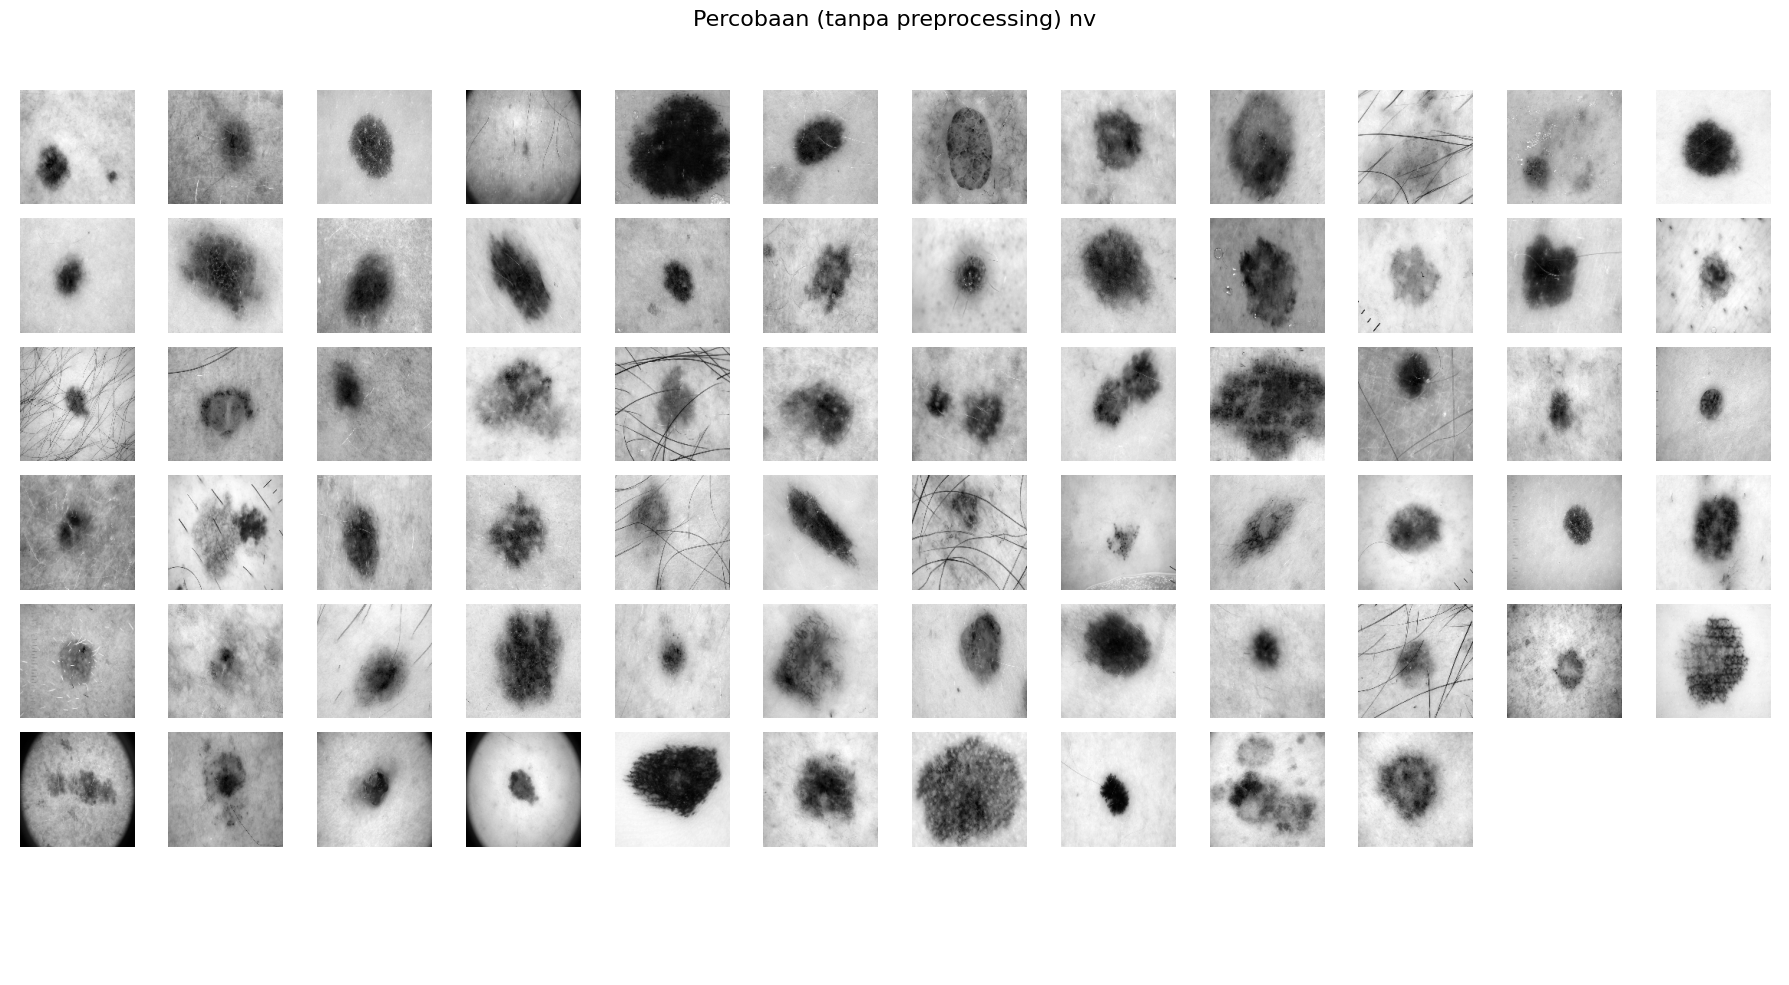

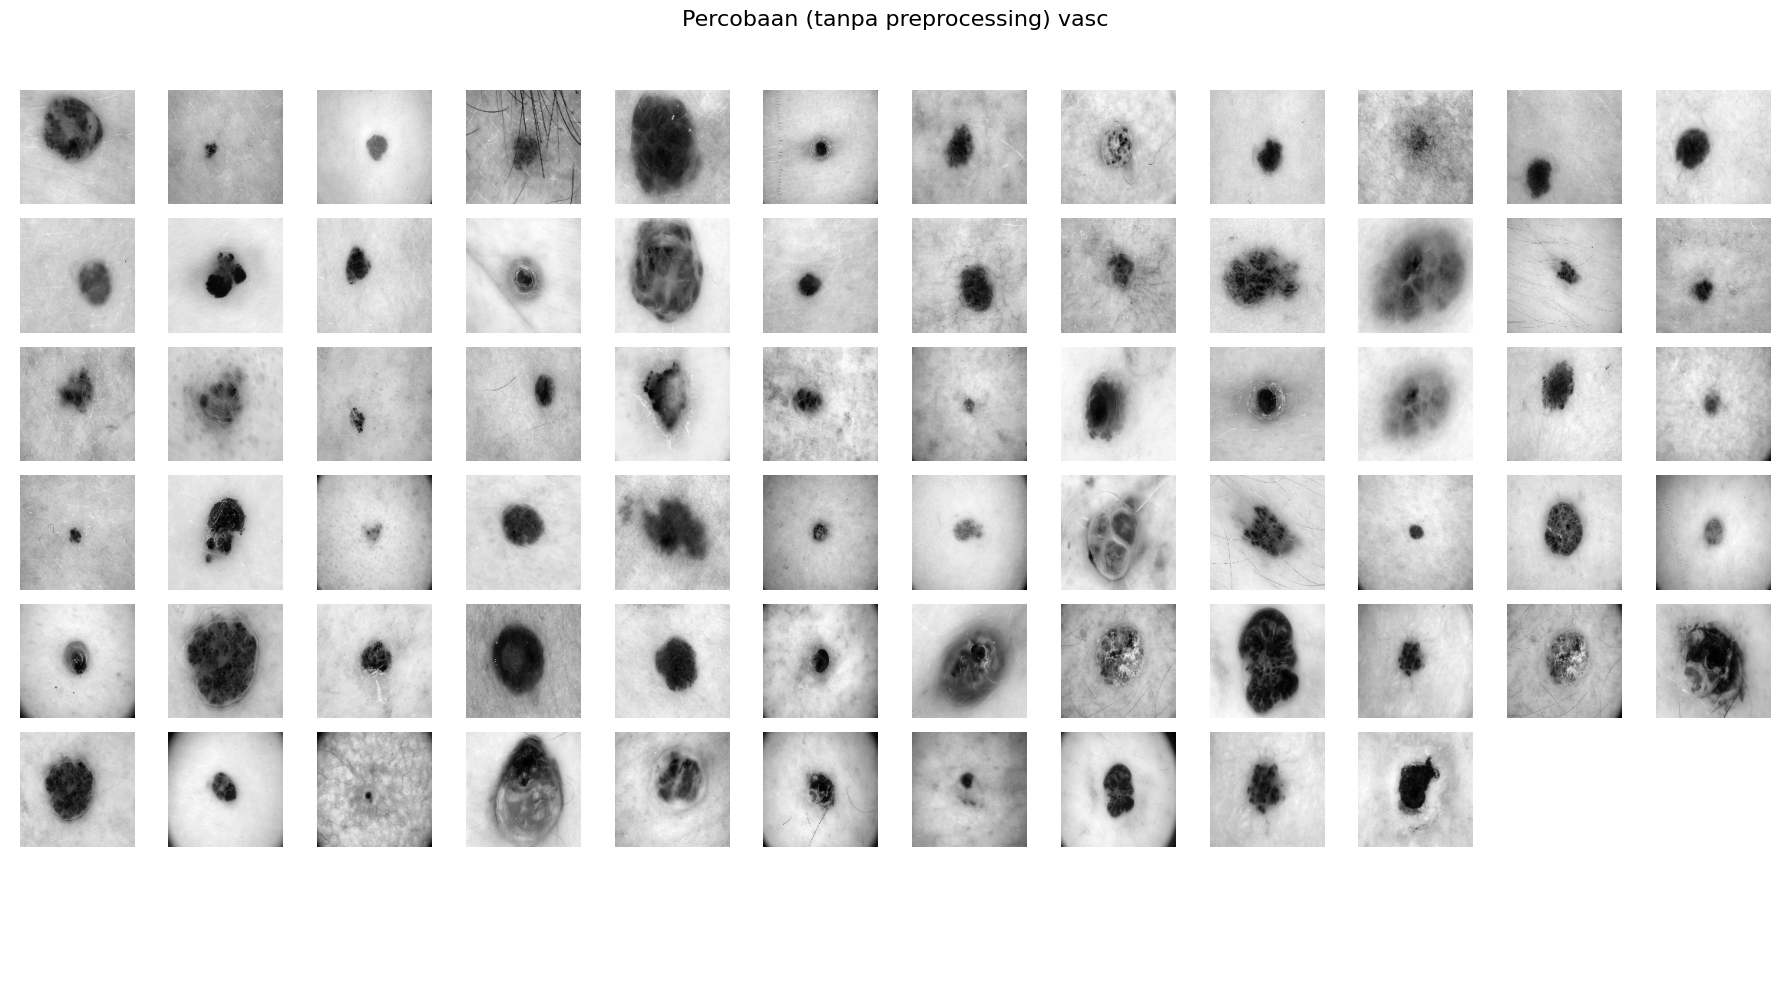

In [4]:
unique_labels = sorted(set(labels))

for label in unique_labels:
    idxs = [j for j, l in enumerate(labels) if l == label]
    n_imgs = min(84, len(idxs))
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan (tanpa preprocessing) {label}', fontsize=16)

    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        if k < n_imgs:
            ax.imshow(data[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


## Ekstrasi Fitur

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

In [8]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [9]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df1 = ekstrak_fitur_glcm(data, 'percobaan1')
display(df1)

contrast  correlation    energy  homogeneity  dissimilarity       ASM  \
0     30.999508     0.953867  0.038948     0.309507       3.146532  0.001517   
1     33.485235     0.946196  0.034684     0.254550       3.885235  0.001203   
2     58.765593     0.955062  0.034024     0.284454       3.940626  0.001158   
3    230.342685     0.842518  0.027693     0.177200       7.801566  0.000767   
4     16.430604     0.902075  0.057814     0.313850       2.853154  0.003342   
..          ...          ...       ...          ...            ...       ...   
485   84.204430     0.973740  0.027902     0.249885       4.696600  0.000779   
486   13.371409     0.984681  0.039010     0.351777       2.488546  0.001522   
487   43.772483     0.989610  0.038636     0.304124       3.747069  0.001493   
488    6.925011     0.991402  0.073053     0.441750       1.777987  0.005337   
489   61.303669     0.985296  0.035512     0.266409       4.250515  0.001261   

      entropy       tahap  
0    6.914421  percobaan1  
1    7.139483  percobaan1  
2    7.276851  percobaan1  
3    7.763550  percobaan1  
4    6.172806  percobaan1  
..        ...         ...  
485  7.676521  percobaan1  
486  6.869814  percobaan1  
487  7.178757  percobaan1  
488  5.879207  percobaan1  
489  7.220225  percobaan1  

[490 rows x 8 columns]

In [10]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data)):
    D0 = glcm(data[i], 0)
    D45 = glcm(data[i], 45)
    D90 = glcm(data[i], 90)
    D135 = glcm(data[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



## Hasil Ekstraksi to CSV

In [11]:
features = []

for i in range(len(data)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


In [12]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan(tanpaPrepro).csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan(tanpaPrepro).csv')
hasilEkstrak


Filename  Label   Contrast0  Contrast45  Contrast90  Contrast135  \
0    ISIC_0024329.jpg  akiec   30.999508   31.402685   22.369172    36.548984   
1    ISIC_0024463.jpg  akiec   33.485235   45.175172   26.589530    39.277420   
2    ISIC_0024511.jpg  akiec   58.765593   47.676141   46.202550    92.442097   
3    ISIC_0024562.jpg  akiec  230.342685  315.063511  358.370694   412.019594   
4    ISIC_0024646.jpg  akiec   16.430604   22.592135   15.055973    21.615288   
..                ...    ...         ...         ...         ...          ...   
485  ISIC_0033458.jpg   vasc   84.204430   96.485564   67.422774    94.118823   
486  ISIC_0033817.jpg   vasc   13.371409   18.937165   14.398881    20.585379   
487  ISIC_0033969.jpg   vasc   43.772483   55.116031   27.281432    60.858520   
488  ISIC_0033991.jpg   vasc    6.925011    9.701455    4.811230     8.797442   
489  ISIC_0034196.jpg   vasc   61.303669   90.237872   42.139150    73.211837   

     Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  ...  \
0        0.309507       0.275700       0.341487        0.282330  ...   
1        0.254550       0.219889       0.275533        0.232476  ...   
2        0.284454       0.274902       0.317846        0.245157  ...   
3        0.177200       0.170617       0.199931        0.154725  ...   
4        0.313850       0.277907       0.328884        0.278021  ...   
..            ...            ...            ...             ...  ...   
485      0.249885       0.244612       0.307130        0.231142  ...   
486      0.351777       0.310357       0.351478        0.298079  ...   
487      0.304124       0.287233       0.343555        0.271022  ...   
488      0.441750       0.406692       0.491672        0.419083  ...   
489      0.266409       0.242574       0.316062        0.241198  ...   

        ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    0.001711  0.001359  0.038948  0.036481  0.041366   0.036867   
1    0.001316  0.001077  0.034684  0.031838  0.036279   0.032824   
2    0.001299  0.000992  0.034024  0.033005  0.036035   0.031498   
3    0.000883  0.000667  0.027693  0.027330  0.029722   0.025829   
4    0.003511  0.002927  0.057814  0.053548  0.059253   0.054105   
..        ...       ...       ...       ...       ...        ...   
485  0.000920  0.000689  0.027902  0.027278  0.030339   0.026258   
486  0.001463  0.001229  0.039010  0.035882  0.038254   0.035050   
487  0.001678  0.001293  0.038636  0.037609  0.040962   0.035960   
488  0.006101  0.004975  0.073053  0.069077  0.078112   0.070537   
489  0.001564  0.001126  0.035512  0.033326  0.039547   0.033555   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.953867       0.953164       0.966750        0.945489  
1        0.946196       0.927475       0.957146        0.936944  
2        0.955062       0.963476       0.965117        0.929200  
3        0.842518       0.785021       0.754863        0.718849  
4        0.902075       0.865628       0.910043        0.871438  
..            ...            ...            ...             ...  
485      0.973740       0.969762       0.979217        0.970506  
486      0.984681       0.978269       0.983597        0.976375  
487      0.989610       0.986891       0.993571        0.985525  
488      0.991402       0.988020       0.994026        0.989136  
489      0.985296       0.978479       0.989908        0.982540  

[490 rows x 30 columns]

## Feature Selection

### Correlation

<Axes: >

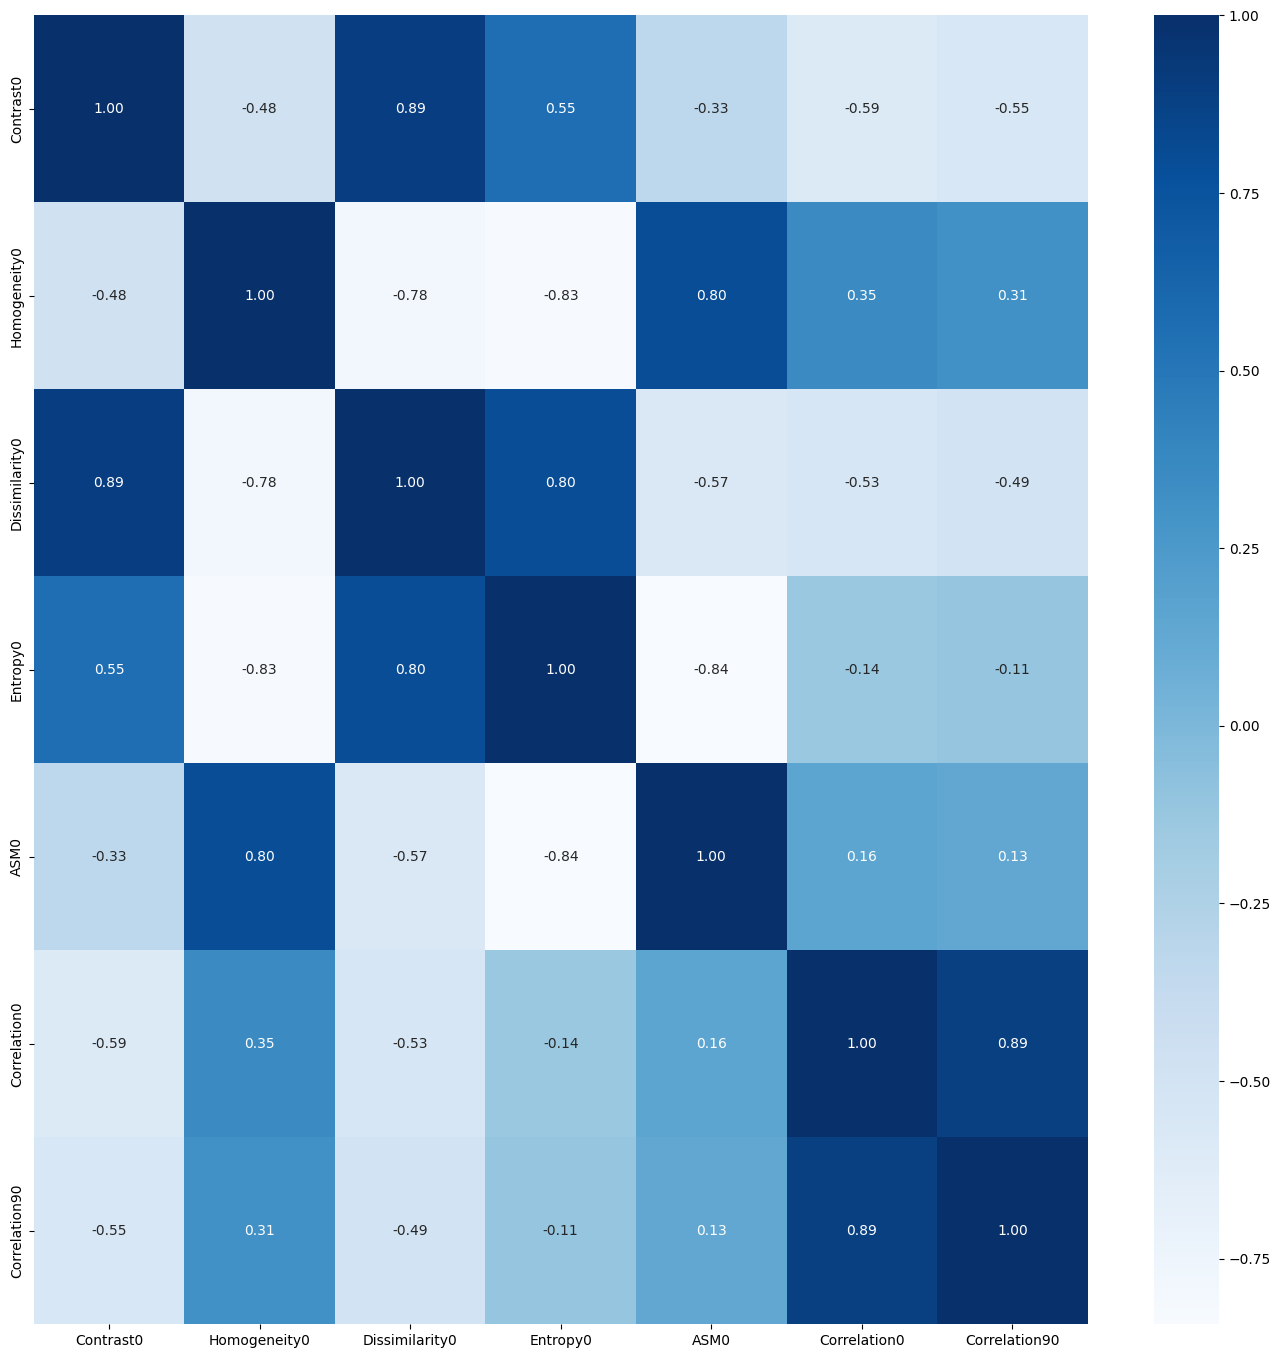

In [13]:
# Selection Correlation
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### LDA

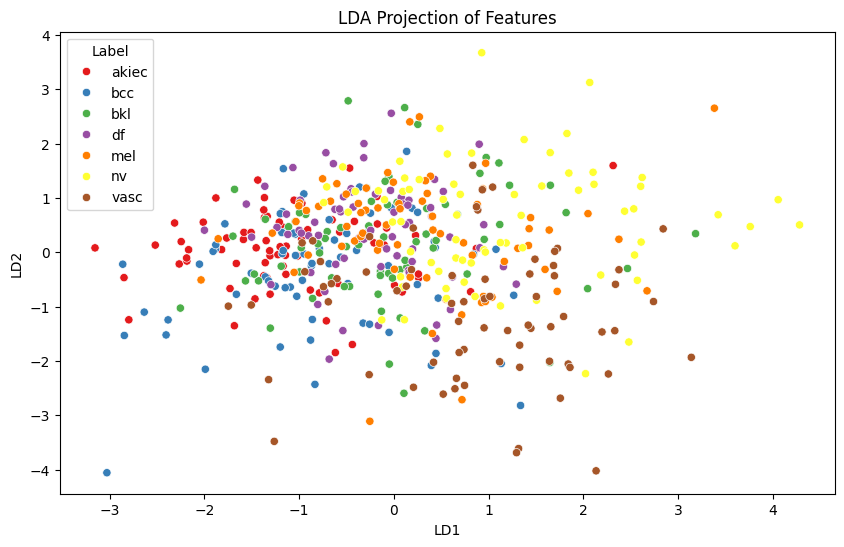

In [14]:
# Selection LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def feature_reduction_lda(dataframe, n_components=2):
    fitur = dataframe.drop(columns=['Label', 'Filename'])
    label = dataframe['Label']
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    x_lda = lda.fit_transform(fitur, label)
    
    columns = [f'LD{i+1}' for i in range(n_components)]
    df_lda = pd.DataFrame(x_lda, columns=columns)
    df_lda['Label'] = label.values
    
    return df_lda

lda_df = feature_reduction_lda(hasilEkstrak, n_components=2)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Label', palette='Set1')
plt.title('LDA Projection of Features')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Label')
plt.show()

### t-SNE

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


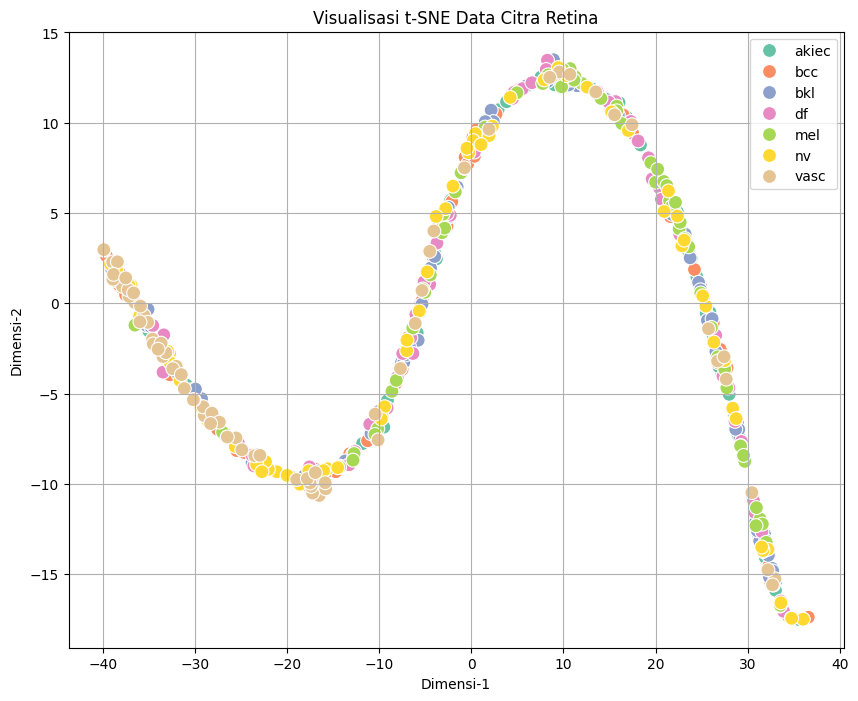

In [15]:
# Selection t-SNE

from sklearn.manifold import TSNE

# Jalankan t-SNE untuk reduksi ke 2 dimensi
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(x_new)

# Buat DataFrame hasil t-SNE
df_tsne = pd.DataFrame()
df_tsne['Dimensi-1'] = X_tsne[:, 0]
df_tsne['Dimensi-2'] = X_tsne[:, 1]
df_tsne['Label'] = y

# Plot dengan seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensi-1', y='Dimensi-2', hue='Label', data=df_tsne, palette='Set2', s=100
)
plt.title('Visualisasi t-SNE Data Citra Retina')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Splitting Data

In [16]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(392, 7)
(98, 7)
(392,)
(98,)


## Feature Normalization

In [17]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [18]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [19]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       akiec       0.86      0.95      0.90        57
         bcc       0.90      0.90      0.90        51
         bkl       0.92      0.90      0.91        60
          df       0.95      0.92      0.93        61
         mel       0.94      0.89      0.92        56
          nv       0.89      0.86      0.88        59
        vasc       0.92      0.96      0.94        48

    accuracy                           0.91       392
   macro avg       0.91      0.91      0.91       392
weighted avg       0.91      0.91      0.91       392

[[54  1  0  0  0  1  1]
 [ 2 46  2  0  0  0  1]
 [ 4  1 54  0  0  1  0]
 [ 1  0  3 56  0  0  1]
 [ 0  1  0  3 50  2  0]
 [ 2  2  0  0  3 51  1]
 [ 0  0  0  0  0  2 46]]
Accuracy: 0.9107142857142857

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.18      0.31      0.23        13
         bcc       0.19      0.16      0.17   

### Train SVM Classifier

In [20]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       akiec       0.39      0.47      0.43        57
         bcc       1.00      0.04      0.08        51
         bkl       0.35      0.15      0.21        60
          df       0.28      0.39      0.33        61
         mel       0.32      0.54      0.40        56
          nv       0.47      0.37      0.42        59
        vasc       0.36      0.52      0.42        48

    accuracy                           0.35       392
   macro avg       0.45      0.36      0.33       392
weighted avg       0.44      0.35      0.33       392

[[27  0  3 17  5  0  5]
 [11  2  3 15  6  3 11]
 [10  0  9 16 14  2  9]
 [10  0  5 24 15  2  5]
 [ 5  0  3  6 30  8  4]
 [ 4  0  2  6 14 22 11]
 [ 2  0  1  1  9 10 25]]
Accuracy: 0.35459183673469385

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.36      0.38      0.37        13
         bcc       0.50      0.05      0.10 

### Train KNN Classifier

In [21]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       akiec       0.36      0.60      0.45        57
         bcc       0.38      0.41      0.40        51
         bkl       0.44      0.45      0.44        60
          df       0.59      0.43      0.50        61
         mel       0.58      0.46      0.51        56
          nv       0.60      0.47      0.53        59
        vasc       0.56      0.52      0.54        48

    accuracy                           0.48       392
   macro avg       0.50      0.48      0.48       392
weighted avg       0.50      0.48      0.48       392

[[34  6  7  4  2  1  3]
 [20 21  7  2  0  1  0]
 [15  5 27  3  5  4  1]
 [12  8  7 26  1  1  6]
 [ 4  7  7  2 26  7  3]
 [ 7  3  3  5  6 28  7]
 [ 2  5  4  2  5  5 25]]
Accuracy: 0.4770408163265306

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.37      0.85      0.51        13
         bcc       0.11      0.05      0.07  

## Evaluasi Dengan Confussion Matrix

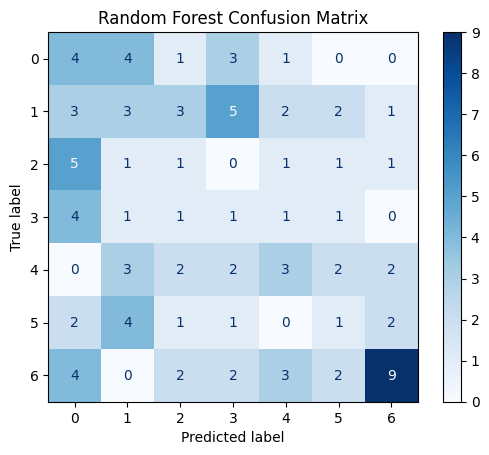

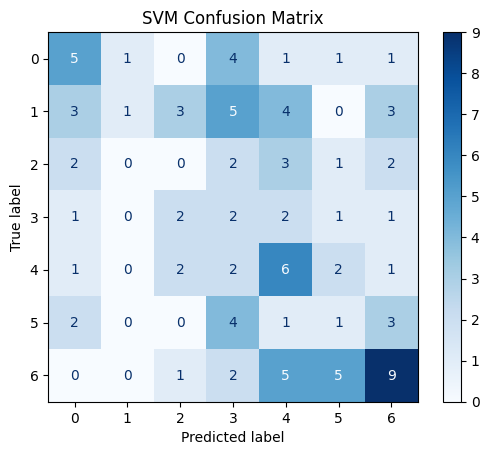

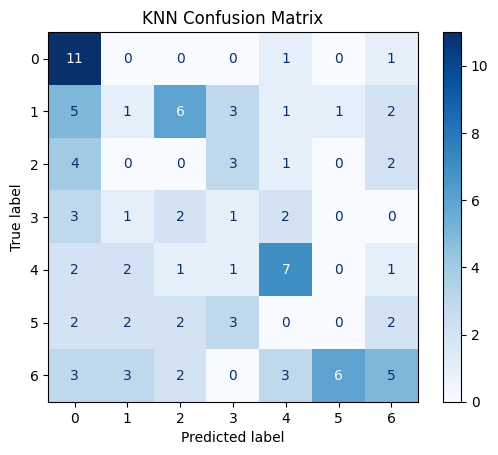

In [22]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")